# Cost-sensitive threshold

Instead of modifying the training procedure to make it cost-sensitive, we can also make the test-time procedure. More specifically, we can **modify the threshold** for a prediction to be classified as positive.

We will classify a positive class probability $P_{+}$ as positive if and only if

$$
P_{+} > \frac{C_{FP}}{C_{FP} + C_{FN}}
$$

As you can see, the higher the false negative cost, the *easier* we will classify a sample as positive.

## Train

> **Note**: you can download the dataset [here](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). Create a new folder called `data` in the directory of this notebook and move the downloaded csv file into that folder. Next, rename the csv file to `creditcard_fraud_dataset.csv`.

In [1]:
from lib.creditcard_fraud_dataset import get_train_test_dfs

df_train, df_test = get_train_test_dfs()

In [2]:
def get_cs_threshs(df):
    return df['C_FP'] / (df['C_FP'] + df['C_FN'])

In [3]:
from lib.cs_train import train_clf


clf = train_clf(
    df_train,
)

## Evaluate

In [4]:
from lib.cs_eval import evaluate_clf


cs_thresh = get_cs_threshs(df_test)

eval_metrics_cs_thresh = evaluate_clf(clf, df_test,
                                      thresh=cs_thresh)
eval_metrics_reg_thresh = evaluate_clf(clf, df_test,
                                       thresh=0.5)

In [5]:
import pandas as pd

df = pd.DataFrame([
    {
        'method': 'Cost-sensitive threshold',
        **eval_metrics_cs_thresh
    },
    {
        'method': 'Regular threshold (0.5)',
        **eval_metrics_reg_thresh
    }
])

In [6]:
df

,method,cost_precision,cost_recall,tp_amount,fp_amount,fn_amount,net
0,Cost-sensitive threshold,0.972386,0.858473,26832.93,762.0,4423.64,21647.29
1,Regular threshold (0.5),0.997766,0.514306,16075.45,36.0,15181.12,858.33


Text(0.5, 1.0, 'Cost Recall')

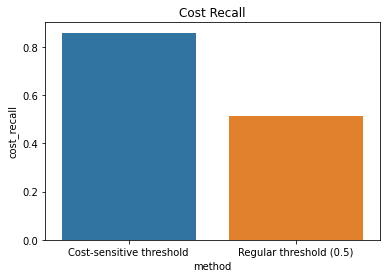

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=df, x='method', y='cost_recall')
plt.title('Cost Recall')

Text(0.5, 1.0, 'Cost Precision')

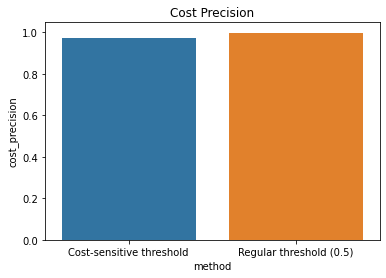

In [8]:
sns.barplot(data=df, x='method', y='cost_precision')
plt.title('Cost Precision')